# Best Model Evaluation
**Use conda_tensorflow2_python 3 kernel!**

In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
!pip install wandb scikit-plot -q

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install tf-nightly -q # may screw up predictions
!pip install sagemaker-tensorflow -q #instead?

ERROR: tensorflow 2.1.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [44]:
import json
import yaml
import wandb
import boto3
import base64
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from botocore.exceptions import ClientError
from containers.training_beta.Model import Model 
from sklearn.metrics import confusion_matrix
from scikitplot.metrics import plot_confusion_matrix, plot_roc

In [45]:
tf.__version__

'2.4.0-dev20200830'

In [46]:
%matplotlib inline

In [47]:
region = 'us-east-2'
metric = 'best_val_classification_accuracy'
entity_id = 'rosenblatt'
project_id = 'satellite-model-and-orientation'
sweep_id = f'{entity_id}/{project_id}/kklngp30'

In [48]:
# TODO: add to a helpers class or something
def get_secret(secret_name, region_name):
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )
    
    get_secret_value_response = client.get_secret_value(
        SecretId=secret_name
    )
    
    if 'SecretString' in get_secret_value_response:
        secret = get_secret_value_response['SecretString']
        return json.loads(secret)
    else:
        decoded_binary_secret = base64.b64decode(get_secret_value_response['SecretBinary'])
        return decoded_binary_secret

In [49]:
assert wandb.login(key=get_secret("wandb_api_key", region)["wandb_api_key"])
!rm -r wandb

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: WARNING Calling wandb.login() without arguments from jupyter should prompt you for an api key.
wandb: Appending key for api.wandb.ai to your netrc file: /home/ec2-user/.netrc


## Architecture Parameter Graph

In [132]:
models = ['ResNet50V2','VGG16','EfficientNetB4','DenseNet201']
weights = [23000000, 134700000, 19000000, 20000000 ]
pal = sns.color_palette("Blues_d", len(models))

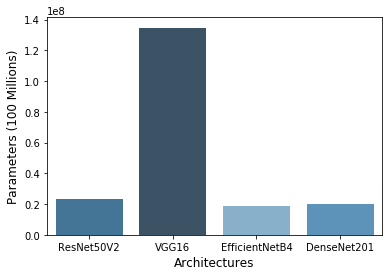

In [133]:
ax = sns.barplot(
    x=models, 
    y=weights, 
    palette=np.array(pal[::-1])[np.argsort(weights)]
)
ylab = ax.set_ylabel('Parameters (100 Millions)')
ylab.set_fontsize(12)
xlab =  ax.set_xlabel('Architectures')
xlab.set_fontsize(12)
plt.show()

## Session 1 Part 2 Top-20 Parameter Utilization

In [124]:
parameters = ['imagenet', 'ResNet50v2', 'GlobalAveraging2D', 'batch size: 64']
utilizations = [18/20, 17/20, 20/20, 17/20]
pal = sns.color_palette("Blues", len(parameters))

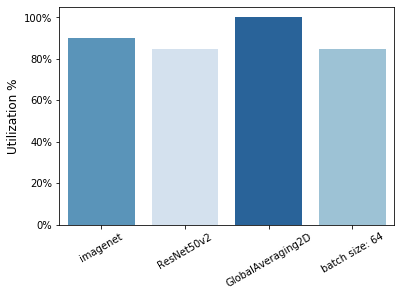

In [131]:
ax = sns.barplot(
    x=parameters,
    y=utilizations, 
    palette=np.array(pal[::-1])[np.argsort(utilizations)]
)
ax.set_xticklabels(parameters, rotation=30)
ax.set_yticklabels([f'{u}%'for u in [0, 20, 40, 60, 80, 100]])
ylab = ax.set_ylabel('Utilization %')
ylab.set_fontsize(12)
plt.show()

## Download Weights of the Best Model

In [52]:
home = !pwd
home = home[0]
best_path = home + '/best'
! [ ! -d $best_path ] && mkdir best

In [53]:
api = wandb.Api()
sweep = api.sweep(sweep_id)
!rm -r wandb

In [54]:
best_run = sorted(sweep.runs, key=lambda run: run.summary.get("best_val_classification_accuracy", 0), reverse=True)[0]
val_cls_acc = best_run.summary.get("best_val_classification_accuracy", 0)
print(f"Best run {best_run.name} with {round(val_cls_acc*100,2)}% validation classification accuracy")

Best run devoted-sweep-132 with 90.46% validation classification accuracy


In [55]:
for file in best_run.files():
    if 'best' in file.name:
        best_run.file(file.name).download(root='best', replace=True)
print("Best model saved to best/model-best.h5")
best_run.file("config.yaml").download(root='best', replace=True)
print("Best configuration save to best/config.yaml")

Best model saved to best/model-best.h5
Best configuration save to best/config.yaml


## Rebuild the Model

In [56]:
# TODO: rebuild the model using config.yaml
config = yaml.load(open('best/config.yaml'), Loader=yaml.FullLoader)
m = Model(config, translation=False)
model = m.tf_model
model.load_weights(f'{best_path}/model-best.h5')

## Upload the model in SavedModel format tp S3

In [63]:
fname = "mutlitask" if config['orientation']['value'] else "classification"
tarname = f"{fname}.tar.gz"
model.save(fname)

INFO:tensorflow:Assets written to: classification/assets


In [65]:
!tar -cz -f $tarname --owner=0 --group=0 -C $fname . && rm -r $fname

In [61]:
def upload_file(file_name, bucket, object_name=None):
    """Upload a file to an S3 bucket

    :param file_name: File to upload
    :param bucket: Bucket to upload to
    :param object_name: S3 object name. If not specified then file_name is used
    :return: True if file was uploaded, else False
    """

    # If S3 object_name was not specified, use file_name
    if object_name is None:
        object_name = file_name

    # Upload the file
    s3_client = boto3.client('s3')
    try:
        response = s3_client.upload_file(file_name, bucket, object_name)
    except ClientError as e:
        logging.error(e)
        return False
    return True

In [70]:
assert upload_file(tarname, 'ssa-data', f'models/{tarname}')
!rm $tarname

## Download Test Dataset and Perform Predictions

In [16]:
from containers.training_beta.DatasetGenerator import DatasetGenerator
images = []
labels = []
predictions = []
# '/home/ec2-user/SageMaker/ssa-data/structured/less_distorted/agena'
test_ds_gen = DatasetGenerator(
    'validation', 
    multitask=config['orientation']['value'], 
    distortion=True, 
    distance=True,
    evaluate=True
)
batch_iter = iter(test_ds_gen)

In [17]:
# TODO: some progress stats would be nice, 128 works fine, ResourceExhaustedError at 142 on ml.t2.medium
for idx, batch in enumerate(range(64)): #range(test_ds_gen.steps):
    batch_images, batch_labels = next(batch_iter)
    images.append(batch_images)
    labels.append(batch_labels)
    batch_pred = model.predict_on_batch(batch_images)
    predictions.append(batch_pred)

failed to parse ('/home/ec2-user/SageMaker/kolmogorov-jay/model/validation/cloudsat/.ipynb_checkpoints', [], ['10_224x224_29.25363,245.483,222.6432_15.62385_8_0.351_100_32.more_distorted-checkpoint.png'])
failed to parse ('/home/ec2-user/SageMaker/kolmogorov-jay/model/validation/ACRIMSAT/.ipynb_checkpoints', [], ['0_224x224_300.2952,200.8264,72.95969_10.23865_8.0_1.6_100.0_32.less_distorted-checkpoint.png'])


In [18]:
if config['orientation']['value']:
    class_labels, orientation_labels, distortion_labels, distance_labels = map(list, zip(*labels))
    class_predictions, orientation_predictions, distortion_labels, distance_labels =  map(list, zip(*predictions))
else:
    class_labels, distortion_labels, distance_labels = map(list, zip(*labels))
    class_predictions = predictions

In [22]:
# TODO: extract only the classification labels and predictions for the confusion matrix
class_predictions = tf.concat(class_predictions, 0)
class_labels = tf.concat(class_labels, 0)
distortion_lables = tf.concat(distortion_labels, 0)
distance_labels = tf.concat(distance_labels, 0)
if config['orientation']['value']:
    orientation_labels = tf.concat(orientation_labels, 0)

## Show 3D Visualization of Model Performance at Different Orientations
**Only if model predicted orientation**

In [1]:
'''
orientation labels used to determine where point lies in scatter plot
class_labels used to determine which class a sat belongs to
prediction is the class the models thinks a sat is
** where do I get confidence?

there are 12 overlapping predictions for each point on the sphere. average results to determine prediction performance display

output structure:
sat_classes
    class
        xs
        ys
        zs
        correct fraction

wandb output: [x, y, z, r, g, b]

How to calculate x,y,z from orientation labels?
'''
import math

from collections import defaultdict
from fractions import Fraction
from pprint import pprint

data_points = defaultdict(lambda: {
    'xs': [],
    'ys': [],
    'zs': [],
    # maps points to the ratio of correct predictions (sats have 3 degrees of rotation, cartesian coords capture only 2) for a particular orientation
    'point_correctness': defaultdict(lambda: {
        'correct': 0,
        'incorrect': 0
    })
})

for index in range(len(predictions)):
    for i, prediction in enumerate(predictions[index]):
        sat_class = np.array(test_ds_gen.classes)[np.argmax(class_labels[index][i].numpy())]
        x = math.cos(orientation_labels[index][i][0])
        y = math.sin(orientation_labels[index][i][0])
        z = math.sin(orientation_labels[index][i][1])
        data_points[sat_class]['xs'].append(x)
        data_points[sat_class]['ys'].append(y)
        data_points[sat_class]['zs'].append(z)

        if tf.math.argmax(prediction) == tf.math.argmax(class_labels[index][i]):
            data_points[sat_class]['point_correctness'][(x,y,z)]['correct'] += 1
        else:
            data_points[sat_class]['point_correctness'][(x,y,z)]['incorrect'] += 1

pprint(data_points.keys())

NameError: name 'predictions' is not defined

In [ ]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(3)
fig.set_figwidth(6)

for index, sat in enumerate(data_points.keys()):
    ax = fig.add_subplot(1, len(data_points.keys()), index+1, projection='3d')

    sat_data = data_points['Dawn']

    colors = []
    for i in range(len(sat_data['xs'])):
        x = sat_data['xs'][i]
        y = sat_data['ys'][i]
        z = sat_data['zs'][i]
        correct = sat_data['point_correctness'][(x,y,z)]['correct']
        incorrect = sat_data['point_correctness'][(x,y,z)]['incorrect']
        total = correct + incorrect
        colors.append([
            incorrect/total,
            correct/total,
            0,
            1
        ])

    ax.scatter(
        sat_data['xs'],
        sat_data['ys'],
        sat_data['zs'],
        c=colors
    )

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

plt.show()

## Plot Confusion Matrices

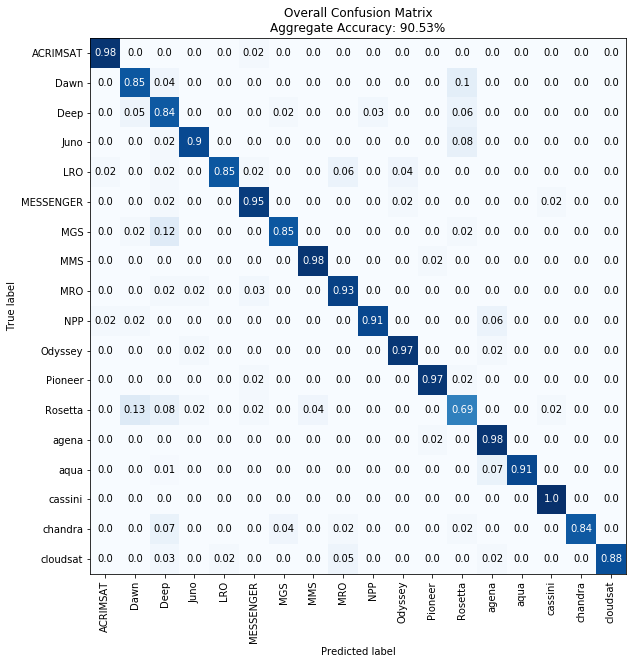

In [24]:
accuracy = np.sum(np.argmax(class_labels, axis=1) == np.argmax(class_predictions, axis=1))/class_labels.shape[0]
ax = plot_confusion_matrix(
        np.array(test_ds_gen.classes)[np.argmax(class_labels, axis=1)], 
        np.array(test_ds_gen.classes)[np.argmax(class_predictions, axis=1)], 
        figsize=(12,12),
        labels=test_ds_gen.classes,
        x_tick_rotation=90,
        normalize=True,
        title=f'Overall Confusion Matrix\nAggregate Accuracy: {round(accuracy*100,2)}%'
    )
cb = ax.images[0].colorbar
cb.remove()
plt.show()

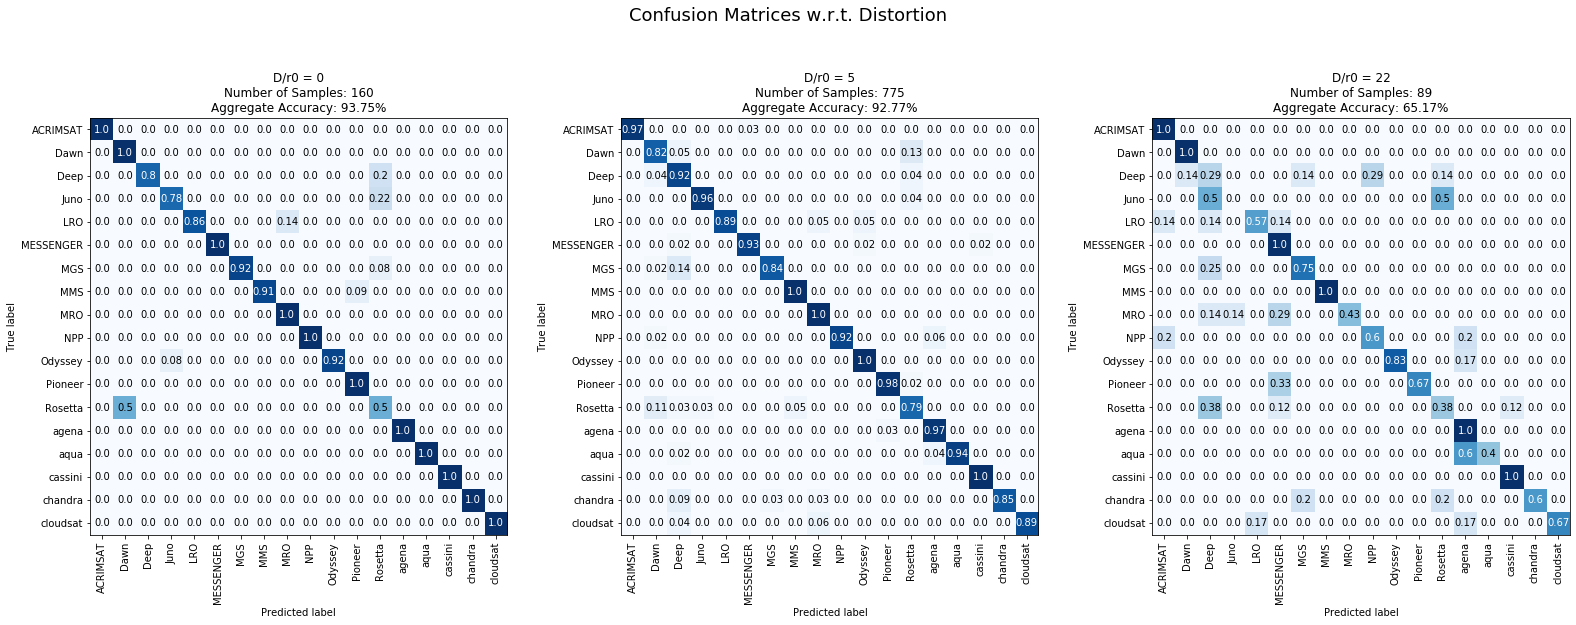

In [25]:
distortion_levels = np.unique(distortion_labels)
fig, axes = plt.subplots(1, len(distortion_levels), figsize=(22,22))
fig.suptitle('Confusion Matrices w.r.t. Distortion', fontsize=18)
for ax, dl in zip(axes.flatten(), distortion_levels):
    cl = class_labels[distortion_lables == dl]
    cp = class_predictions[distortion_lables == dl]
    cl = np.argmax(cl, axis=1)
    cp = np.argmax(cp, axis=1)
    num_samples = cl.shape[0]
    accuracy = np.sum(cl == cp)/num_samples
    plot_confusion_matrix(
        np.array(test_ds_gen.classes)[cl], 
        np.array(test_ds_gen.classes)[cp], 
        labels=test_ds_gen.classes,
        x_tick_rotation=90,
        normalize=True,
        ax=ax
    )
    cb = ax.images[0].colorbar
    cb.remove()
    ax.title.set_text(f'D/r0 = {int(dl)}\nNumber of Samples: {num_samples}\nAggregate Accuracy: {round(accuracy*100,2)}%')
plt.tight_layout(w_pad=3.0, h_pad=0.0)
fig.subplots_adjust(top=1.55)
plt.show()

## Orientation Report

## Pixel Sparsity Report

In [1]:
# TODO: measure how pixel sparsity impacted the model accuracy
np.min(distance_labels)

NameError: name 'np' is not defined

### Inference Demo

In [38]:
def inference_demo(model, images, class_predictions, class_labels, classes):
    plt.figure(figsize=(10,10))
    for n in range(min(16, min(len(class_predictions),len(class_labels)))):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(images[n])
        plt.title('Truth: ' + tf.boolean_mask(classes, class_labels[n])[0].numpy().decode() +
                  '\nPrediction: ' + test_ds_gen.classes[np.argmax(class_predictions[n])] +
                  '\nConfidence: ' + str(round(np.max(class_predictions[n]*100),1)) + '%'
                 )

        plt.axis('off')

    plt.subplots_adjust(top=1.2, right = 1.0)
    plt.show()

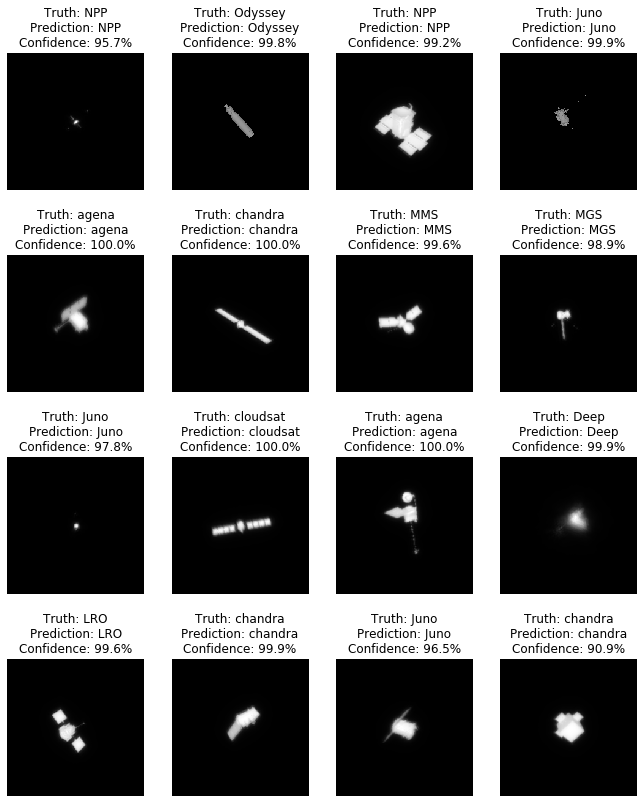

In [53]:
random_idx = np.random.randint(64)
inference_demo(
    model, 
    images[random_idx], 
    class_predictions[random_idx:random_idx+test_ds_gen.batch], 
    class_labels[random_idx:random_idx+test_ds_gen.batch], 
    test_ds_gen.classes
)

## Qualitative Dataset Demo

In [51]:
# show all 18 satellites at their closest distance with no distortion
# show at maximum distance and maximum distortion